In [5]:
# Start by importing all the things we'll need.
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, LSTM, Flatten, TimeDistributed, Dropout, LSTMCell, RNN, Bidirectional, Concatenate, Layer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.utils import tf_utils
from tensorflow.keras import backend as K

import unicodedata
import re
import numpy as np
import os
import time
import shutil

import pandas as pd
import numpy as np
import string, os 
tf.__version__

'2.1.0'

In [6]:
file = open("./dataset.txt", 'r')
corpus = [line.strip() for line in file]

In [7]:
corpus

["I don't like it, but here it is Beth",
 'sister in Eldorado 870-881-0841',
 'Go to "Bulletin Board" Select "Operationally Available"',
 'Can we discuss today?',
 'Please respond to kelly.',
 'johnson',
 "Here's a brief IT project summary if we have time to talk about IT today.",
 '--anthony',
 'need correct pin code for call with sanders.',
 'thanks, jeff',
 'No I do not.',
 '',
 '_______ Get more from the Web.',
 'FREE MSN Explorer download :  - Mvc-123v.',
 'mpg',
 'Enjoy! - 20011205ERCOT_LOAD.',
 'XLS - 20011205ERCOT_FLOW.',
 'XLS',
 'Have a wonderful day.',
 "I'm gone to the Cadillac Bar for our Christmas Luncheon.",
 '',
 '3:30 - ICE Presentation in EB32C2.',
 "4:00 - Trader's Round Table Meeting in EB3321",
 'anthonymends@hotmail.',
 'com',
 'Ben, - Did you talk to Berney about heat rate(10500 vs 10200)? - Will Garrett run 5x8 or 7x8?',
 "Jerry - My trader, Eric, was able to sell the he 7-11 5 mw's for $14.",
 'Please see the attached: JMF',
 'Hi!',
 'FWD: r in an old shaker mi

In [8]:
corpus[40:50]

['',
 '?',
 "Deal #'s: Q08784 legs 1&2; Q08787 legs1&2 Thanks, Errol McLaughlin X5-8274",
 'are you up for golf saturday or sunday??',
 'my week six pick is cincinatti bengals.',
 'Thanks',
 'Enjoy! - 20020114ERCOT_LOAD.',
 'XLS - 20020114ERCOT_FLOW.',
 'XLS',
 'November 6, 2000 Teco Tap 30.']

In [9]:
def clean_special_chars(text, punct):
    for p in punct:
        text = text.replace(p, '')
    return text

      
def preprocess(data):
    output = []
    punct = '#$%&*+-/<=>@[\\]^_`{|}~\t\n'
    for line in data:
         pline= clean_special_chars(line.lower(), punct)
         output.append(pline)
    return output  


def generate_dataset():
  
    processed_corpus = preprocess(corpus)    
    output = []
    for line in processed_corpus:
        token_list = line
        for i in range(1, len(token_list)):
            data = []
            x_ngram = '<start> '+ token_list[:i+1] + ' <end>'
            y_ngram = '<start> '+ token_list[i+1:] + ' <end>'
            data.append(x_ngram)
            data.append(y_ngram)
            output.append(data)
    print("Dataset prepared with prefix and suffixes for teacher forcing technique")
    dummy_df = pd.DataFrame(output, columns=['input','output'])
    return output, dummy_df            
    

In [10]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()
        self.create_index()
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))
        self.vocab = sorted(self.vocab)
        self.word2idx["<pad>"] = 0
        self.idx2word[0] = "<pad>"
        for i,word in enumerate(self.vocab):
            self.word2idx[word] = i + 1
            self.idx2word[i+1] = word

def max_length(t):
    return max(len(i) for i in t)

def load_dataset():
    pairs,df = generate_dataset()
    out_lang = LanguageIndex(sp for en, sp in pairs)
    in_lang = LanguageIndex(en for en, sp in pairs)
    input_data = [[in_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    output_data = [[out_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]

    max_length_in, max_length_out = max_length(input_data), max_length(output_data)
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_data, maxlen=max_length_in, padding="post")
    output_data = tf.keras.preprocessing.sequence.pad_sequences(output_data, maxlen=max_length_out, padding="post")
    return input_data, output_data, in_lang, out_lang, max_length_in, max_length_out, df

In [11]:
input_data, teacher_data, input_lang, target_lang, len_input, len_target, df = load_dataset()


target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# Shuffle all of the data in unison. This training set has the longest (e.g. most complicated) data at the end,
# so a simple Keras validation split will be problematic if not shuffled.

p = np.random.permutation(len(input_data))
input_data = input_data[p]
teacher_data = teacher_data[p]
target_data = target_data[p]



Dataset prepared with prefix and suffixes for teacher forcing technique


In [12]:
pd.set_option('display.max_colwidth', -1)
BUFFER_SIZE = len(input_data)
BATCH_SIZE = 128
embedding_dim = 300
units = 128
vocab_in_size = len(input_lang.word2idx)
vocab_out_size = len(target_lang.word2idx)
df.iloc[200:205]

,input,output
200,<start> here's a brief it project summary if <end>,<start> we have time to talk about it today. <end>
201,<start> here's a brief it project summary if <end>,<start> we have time to talk about it today. <end>
202,<start> here's a brief it project summary if w <end>,<start> e have time to talk about it today. <end>
203,<start> here's a brief it project summary if we <end>,<start> have time to talk about it today. <end>
204,<start> here's a brief it project summary if we <end>,<start> have time to talk about it today. <end>


In [13]:
# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)

# Use this if you dont need Bidirectional LSTM
# encoder_lstm = CuDNNLSTM(units=units, return_sequences=True, return_state=True)
# encoder_out, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))

encoder_lstm = Bidirectional(LSTM(units=units, return_sequences=True, return_state=True))
encoder_out, fstate_h, fstate_c, bstate_h, bstate_c = encoder_lstm(encoder_emb(encoder_inputs))
state_h = Concatenate()([fstate_h,bstate_h])
state_c = Concatenate()([bstate_h,bstate_c])
encoder_states = [state_h, state_c]


# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units*2, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers added to this model to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
decoder_out = decoder_d2(Dropout(rate=.2)(decoder_d1(Dropout(rate=.2)(decoder_lstm_out))))


# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs= decoder_out)

# We'll use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.
# Adam is used because it's, well, the best.

model.compile(optimizer=keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 24, 300)      3736200     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 24, 256), (N 439296      embedding[0][0]                  
______________________________________________________________________________________________

In [14]:
# Note, we use 20% of our data for validation.
epochs = 10
history = model.fit([input_data, teacher_data], target_data,
                 batch_size= BATCH_SIZE,
                 epochs=epochs,
                 validation_split=0.2)


Train on 60600 samples, validate on 15150 samples
Epoch 1/10
60600/60600 [==============================] - 798s 13ms/sample - loss: 1.7120 - sparse_categorical_accuracy: 0.7975 - val_loss: 1.2960 - val_sparse_categorical_accuracy: 0.8144
Epoch 2/10
60600/60600 [==============================] - 774s 13ms/sample - loss: 1.1846 - sparse_categorical_accuracy: 0.8186 - val_loss: 1.0424 - val_sparse_categorical_accuracy: 0.8289
Epoch 3/10
60600/60600 [==============================] - 754s 12ms/sample - loss: 0.9531 - sparse_categorical_accuracy: 0.8354 - val_loss: 0.8214 - val_sparse_categorical_accuracy: 0.8581
Epoch 4/10
60600/60600 [==============================] - 763s 13ms/sample - loss: 0.7513 - sparse_categorical_accuracy: 0.8621 - val_loss: 0.6498 - val_sparse_categorical_accuracy: 0.8876
Epoch 5/10
60600/60600 [==============================] - 814s 13ms/sample - loss: 0.6026 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.5504 - val_sparse_categorical_accuracy: 0.9063
Epoch

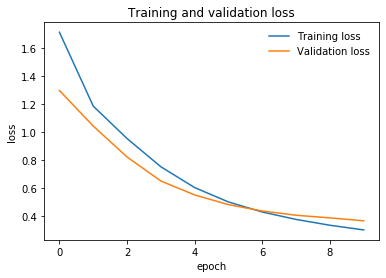

In [26]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend(loc='upper right', frameon=False)
plt.title('Training and validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

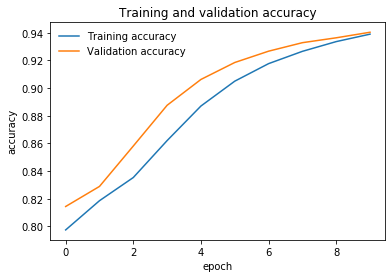

In [25]:
# Plot the results of the training.
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'], label="Training accuracy")
plt.plot(history.history['val_sparse_categorical_accuracy'], label="Validation accuracy")
plt.legend(loc='upper left', frameon=False)
plt.title('Training and validation accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

In [21]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


In [16]:
model.save('my_model.h5') 

In [88]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_out, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).

inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units*2,), name="state_input_h")
state_input_c = Input(shape=(units*2,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])

In [89]:
# Converts the given sentence (just a string) into a vector of word IDs
# Output is 1-D: [timesteps/words]

def sentence_to_vector(sentence, lang):

    pre = sentence
    vec = np.zeros(len_input)
    sentence_list = [lang.word2idx[s] for s in pre.split(' ')]
    for i,w in enumerate(sentence_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
def translate(input_sentence, infenc_model, infmodel):
    sv = sentence_to_vector(input_sentence, input_lang)
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = target_lang.word2idx["<start>"]
    stop_vec = target_lang.word2idx["<end>"]
    
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "<start>"
    output_sentence = ""

    while cur_word != "<end>" and i < (len_target-1):
        i += 1
        if cur_word != "<start>":
            output_sentence = output_sentence + " " + cur_word
        x_in = [cur_vec, sh, sc]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = target_lang.idx2word[np.argmax(nvec[0,0])]
    return output_sentence

In [272]:
#Note that only words that we've trained the model on will be available, otherwise you'll get an error.




test = [
    
    'If you have any questions',
    'Sorry for',
    'Please see th',
    'Would you ple',
    ' Let me know if',
    ' Call me when',
    'Please click on',
    'please fill out',
     'Please note  ',

    
   

    
    
    ]

import pandas as pd
output = []  
for t in test:  
  output.append({"Input seq":t.lower(), "Pred. Seq":translate(t.lower(), encoder_model, inf_model)})

results_df = pd.DataFrame.from_dict(output) 
results_df.head(len(test))

,Input seq,Pred. Seq
0,if you have any questions,please let me know what you think.
1,sorry for,the delay! shona
2,please see th,e attached articles:
3,would you ple,ease find the ap article regarding today's hearing.
4,let me know if,you get a chance.
5,call me when,you get a minute.
6,please click on,the url below for enron's 2001 holiday schedule.
7,please fill out,the following post ids for me please: 684492 703886 725784 thanks for you help pl
8,please note,the attached memo and mark your earlier revisions.
